# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (50, 400), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 78.

In [1]:
extract_zips()

# Transition probabilities

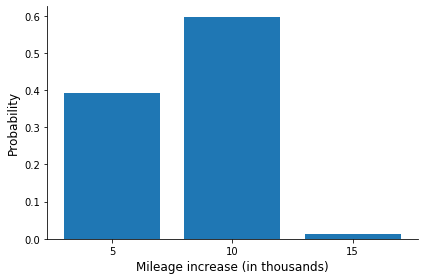

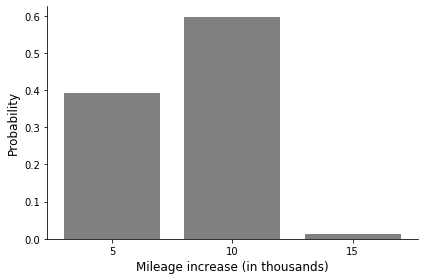

In [2]:
state = 15
get_probabilities(state)

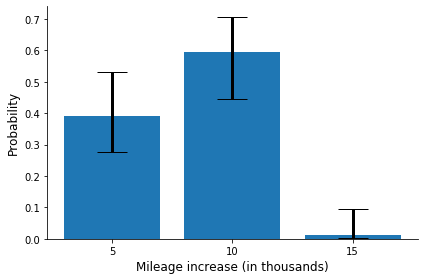

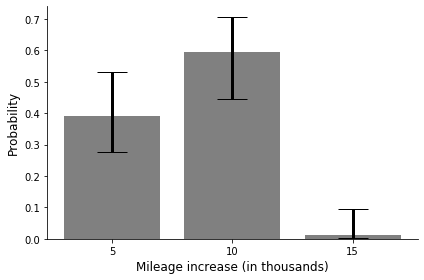

In [3]:
get_probabilities_bar(15)

In [4]:
df_probability_shift(state)

,0,4292_0.50,4292_0.95
0,0.391892,0.316527,0.239203
1,0.595294,0.665835,0.736000
2,0.012815,0.017638,0.024796
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


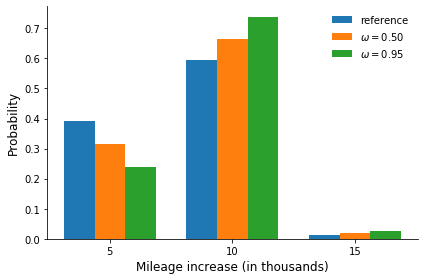

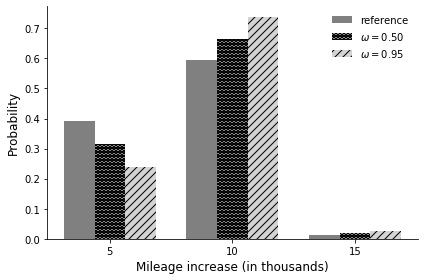

In [5]:
get_probability_shift(state)

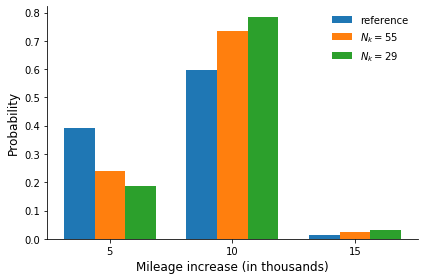

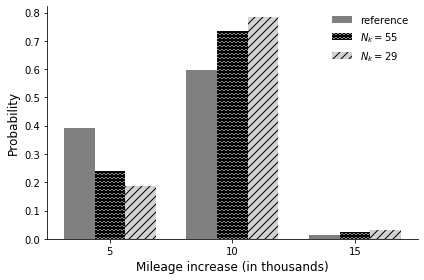

In [6]:
get_probability_shift_data(state)

# Policy Features
 

In [7]:
df_maintenance_probabilties()

,milage_thousands,0.0,0.5,0.95
0,0,1.000000e+00,1.000000e+00,1.000000e+00
1,5,1.000000e+00,1.000000e+00,1.000000e+00
2,10,1.000000e+00,1.000000e+00,1.000000e+00
3,15,1.000000e+00,1.000000e+00,1.000000e+00
4,20,1.000000e+00,1.000000e+00,1.000000e+00
5,25,1.000000e+00,1.000000e+00,1.000000e+00
6,30,9.999993e-01,9.999998e-01,1.000000e+00
7,35,9.999709e-01,9.999931e-01,9.999983e-01
8,40,9.993687e-01,9.998372e-01,9.999565e-01
9,45,9.928007e-01,9.978160e-01,9.993470e-01


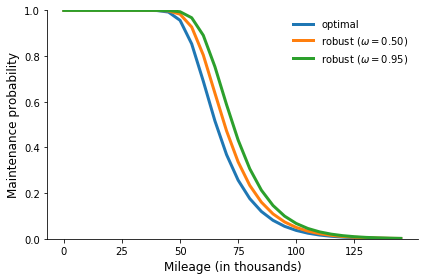

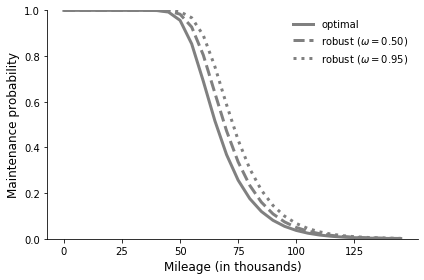

In [8]:
get_maintenance_probabilities()

# Policy performance

In [9]:
max_period = 50
get_demonstration_df()[:max_period]

,months,opt_mileage,rob_mileage
0,0,0,0
1,1,5,5
2,2,5,5
3,3,10,10
4,4,20,20
5,5,25,25
6,6,30,30
7,7,30,30
8,8,35,35
9,9,40,40


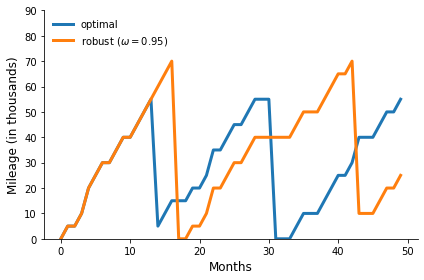

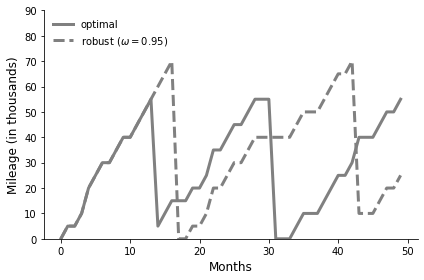

In [10]:
get_demonstration(max_period)

In [11]:
df_thresholds()

,omega,threshold
0,0.00,12
1,0.01,12
2,0.02,12
3,0.03,12
4,0.04,12
...,...,...
95,0.95,14
96,0.96,14
97,0.97,14
98,0.98,14


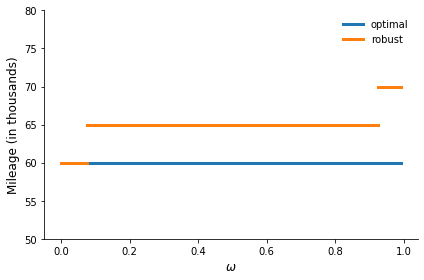

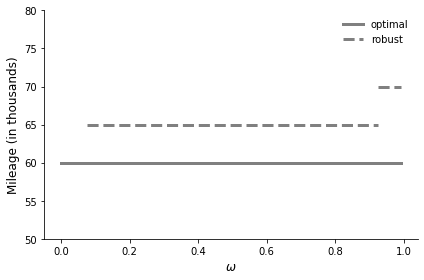

In [12]:
get_replacement_thresholds()

In [13]:
get_decision_rule_df()

,months,disc_strategy,exp_value
0,0,0.000000,-46985.962584
1,1000,-5047.415988,-46985.962584
2,2000,-9651.759569,-46985.962584
3,3000,-13810.379365,-46985.962584
4,4000,-17578.803852,-46985.962584
...,...,...,...
66,66000,-53319.252849,-46985.962584
67,67000,-53326.165142,-46985.962584
68,68000,-53332.422462,-46985.962584
69,69000,-53338.093717,-46985.962584


The underlying transition matrix is the worst case given omega=0.95


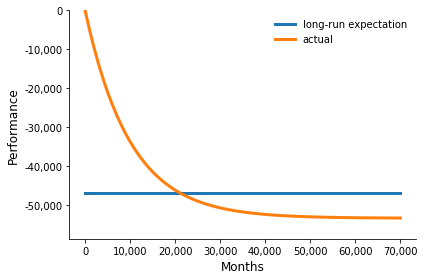

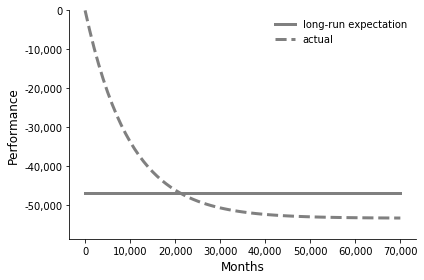

In [14]:
get_performance_decision_rules()

In [15]:
df = get_difference_df()

The dataframe contains the difference for robust - nominal strategy.


In [16]:
df[df["omega"] == 0.01]

,omega,robust_95,robust_050
1,0.01,-227.401716,-56.400252


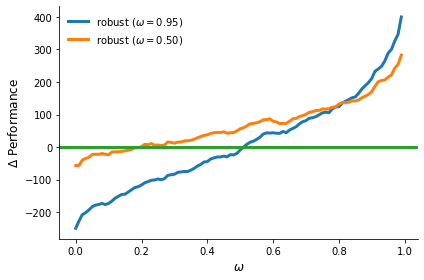

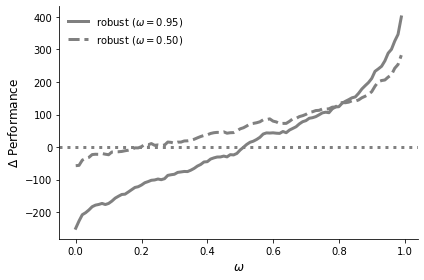

In [17]:
get_difference_plot()

# Out of sample performance

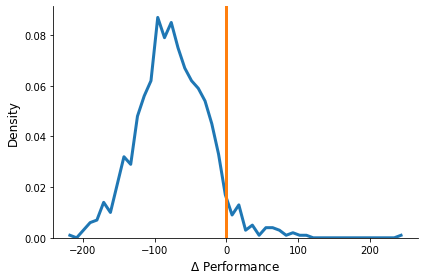

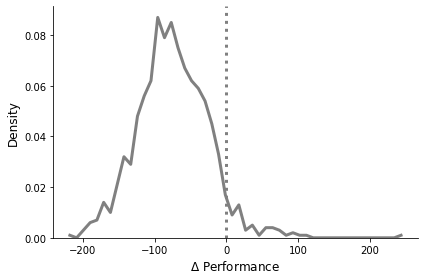

In [18]:
get_out_of_sample_diff(0.50, 50, 4292)

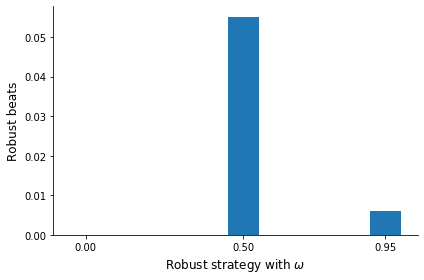

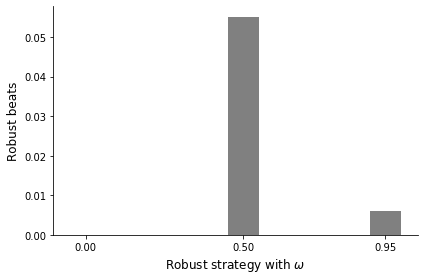

In [19]:
key = [0.5, 0.95]
width = 0.1
sample_size = 4292
get_robust_performance(keys, width, sample_size)